In [391]:
import numpy as np
import pandas as pd
import talib
import pandas_ta as pta
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib import pyplot as plt
from decimal import ROUND_HALF_UP, Decimal

import warnings
warnings.filterwarnings('ignore')

In [414]:
def adjust_price(price):
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        df = df.sort_values("Date")
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    return price

In [415]:
def z_score(df):
    return stats.zscore(df)

In [421]:
class Correlation:

    def __init__(self):
        pass

    def compute_correlation(self, data, method):
        # get correlations of each features in dataset
        corrmat = data.corr(method).abs()
        get_flag_of_show_corrmat = True
        if get_flag_of_show_corrmat:
            top_corr_features = corrmat.index
            plt.figure(figsize=(100, 100))
            # plot heat map
            g = sns.heatmap(data[top_corr_features].corr(method), annot=True, cmap="RdYlGn")

        return corrmat

    def reducing_dimension(self, cor_matrix, th):
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > th)]
        return to_drop

In [416]:
def interpolate_nan(df):
    sec_codes = df.SecuritiesCode.unique().tolist()
    for code in sec_codes:
        df.loc[df.SecuritiesCode == code, "High"] = df[df.SecuritiesCode == code]["High"].interpolate(method='spline', order=3, limit_direction='both')
        df.loc[df.SecuritiesCode == code, "Low"] = df[df.SecuritiesCode == code]["Low"].interpolate(method='spline', order=3, limit_direction='both')
        df.loc[df.SecuritiesCode == code , "Close"] = df[df.SecuritiesCode == code]["Close"].interpolate(method='spline', order=3, limit_direction='both')
        df.loc[df.SecuritiesCode == code , "Open"] = df[df.SecuritiesCode == code]["Open"].interpolate(method='spline', order=3, limit_direction='both')
    return df

In [417]:
class ta:
    @classmethod
    def SMA(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Simple moving average
        """
        return pd.Series(
            data=ohlc[column].rolling(window=period).mean(),
            dtype=float,
            name=f'{period} period SMA'
        )

    @classmethod
    def SMM(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Simple moving median, an alternative to moving average
        """
        return pd.Series(
            data=ohlc[column].rolling(window=period).median(),
            dtype=float,
            name=f'{period} period SMM'
        )

    @classmethod
    def SSMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Smoothed simple moving average
        """
        return pd.Series(
            ohlc[column].ewm(ignore_na=False, alpha=1.0 / period, min_periods=0, adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period SSMA'
        )

    @classmethod
    def EMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Exponential Moving Average
        """
        return pd.Series(
            data=ohlc[column].ewm(span=period, adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period EMA'
        )

    @classmethod
    def DEMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Double Exponential Moving Average
        """
        return pd.Series(
            data=2 * cls.EMA(ohlc, period, column) - cls.EMA(ohlc, period, column).ewm(span=period,
                                                                                       adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period DEMA'
        )

    @classmethod
    def TEMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Triple exponential moving average
        """
        triple_ema = 3 * cls.EMA(ohlc, period, column)
        ema_ema_ema = (
            cls.EMA(ohlc, period, column).
            ewm(ignore_na=False, span=period, adjust=adjust).mean().
            ewm(ignore_na=False, span=period, adjust=adjust).mean()
        )
        return pd.Series(
            data=triple_ema - 3 * cls.EMA(ohlc, period, column).ewm(span=period, adjust=adjust).mean() + ema_ema_ema,
            dtype=float,
            name=f'{period} period TEMA'
        )

    @classmethod
    def TRIMA(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Triangular Moving Average
        """
        return pd.Series(
            data=cls.SMA(ohlc, period, column).rolling(window=period).sum() / period,
            dtype=float,
            name=f'{period} period TRIMA'
        )

    @classmethod
    def TRIX(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        The TRIX indicator calculates the rate of change of a triple exponential moving average.
        The values oscillate around zero. Buy/sell signals are generated when the TRIX crosses above/below zero.
        """
        data = ohlc[column]

        def _ema(data, period, adjust):
            return pd.Series(data.ewm(span=period, adjust=adjust).mean())

        m = _ema(_ema(_ema(data, period, adjust), period, adjust), period, adjust)
        return pd.Series(
            data=100 * (m.diff() / m),
            dtype=float,
            name=f'{period} period TRIX'
        )

    @classmethod
    def VAMA(cls, ohlcv, period=10, column='Close') -> pd.Series:
        """
        Volume Adjusted Moving Average
        """
        vp = ohlcv['Volume'] * ohlcv[column]
        vol_sum = ohlcv['Volume'].rolling(window=period).mean()
        vol_ratio = pd.Series(vp / vol_sum, name="VAMA")
        cum_sum = (vol_ratio * ohlcv[column]).rolling(window=period).sum()
        cum_div = vol_ratio.rolling(window=period).sum()

        return pd.Series(
            data=cum_sum / cum_div,
            dtype=float,
            name=f'{period} period VAMA'
        )

    @classmethod
    def WMA(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Weighted moving average
        """
        denominator = (period * (period + 1)) / 2
        weights = np.arange(1, period + 1)

        def linear(w):
            def _compute(x):
                return (w * x).sum() / denominator

            return _compute

        _close = ohlc[column].rolling(period, min_periods=period)
        return pd.Series(
            data=_close.apply(linear(weights), raw=True),
            dtype=float,
            name=f'{period} period WMA',
        )

    @classmethod
    def SMMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Smoothed Moving Average gives recent prices an equal weighting to historic prices.
        """
        return pd.Series(
            data=ohlc[column].ewm(alpha=1 / period, adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period SMMA'
        )

    @classmethod
    def MACD(cls, ohlc, period_fast=12, period_slow=26, signal=9, column='Close', adjust=True) \
            -> [pd.Series, pd.Series, pd.Series]:
        """
        MACD, MACD Signal and MACD difference
        """
        EMA_fast = pd.Series(
            ohlc[column].ewm(ignore_na=False, span=period_fast, adjust=adjust).mean(),
            dtype=float,
            name='EMA_fast'
        )
        EMA_slow = pd.Series(
            ohlc[column].ewm(ignore_na=False, span=period_slow, adjust=adjust).mean(),
            dtype=float,
            name='EMA_slow'
        )
        MACD = pd.Series(
            EMA_fast - EMA_slow,
            dtype=float,
            name='MACD'
        )
        MACD_signal = pd.Series(
            MACD.ewm(ignore_na=False, span=signal, adjust=adjust).mean(),
            dtype=float,
            name='SIGNAL'
        )
        MACD_difference = MACD - MACD_signal
        return [MACD, MACD_signal, MACD_difference]

    @classmethod
    def MOM(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Market momentum
        """
        return pd.Series(
            data=ohlc[column].diff(period),
            dtype=float,
            name=f'{period} period MOM'
        )

    @classmethod
    def ROC(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        The Rate-of-Change indicator
        """
        return pd.Series(
            data=(ohlc[column].diff(period) / ohlc[column].shift(period)) * 100,
            dtype=float,
            name='ROC'
        )

    @classmethod
    def RSI(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Relative Strength Index
        """
        delta = ohlc[column].diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0

        # EMAs of ups and downs
        _gain = up.ewm(alpha=1.0 / period, adjust=adjust).mean()
        _loss = down.abs().ewm(alpha=1.0 / period, adjust=adjust).mean()
        RS = _gain / _loss
        return pd.Series(
            data=100 - (100 / (1 + RS)),
            dtype=float,
            name=f'{period} period RSI'
        )

    @classmethod
    def TR(cls, ohlc) -> pd.Series:
        """
        True Range is the maximum of three price ranges.
        Most recent period's high minus the most recent period's low.
        Absolute value of the most recent period's high minus the previous close.
        Absolute value of the most recent period's low minus the previous close.
        """
        TR1 = pd.Series(ohlc['High'] - ohlc['Low']).abs()
        TR2 = pd.Series(ohlc['High'] - ohlc['Close'].shift()).abs()
        TR3 = pd.Series(ohlc['Close'].shift() - ohlc['Low']).abs()
        _TR = pd.concat([TR1, TR2, TR3], axis=1)
        _TR['TR'] = _TR.max(axis=1)
        return pd.Series(
            data=_TR['TR'],
            dtype=float,
            name='TR'
        )

    @classmethod
    def ATR(cls, ohlc, period=10) -> pd.Series:
        """
        Average True Range is moving average of True Range.
        """
        TR = cls.TR(ohlc)
        return pd.Series(
            data=TR.rolling(center=False, window=period).mean(),
            dtype=float,
            name=f'{period} period ATR'
        )

    @classmethod
    def BBANDS(cls, ohlc, period=14, MA=None, column="Close", std_multiplier=2) -> [pd.Series, pd.Series, pd.Series]:
        """
         Bollinger Bands
         """

        std = ohlc[column].rolling(window=period).std()
        if not isinstance(MA, pd.Series):
            middle_band = pd.Series(cls.SMA(ohlc, period), dtype=float, name='BB_MIDDLE')
        else:
            middle_band = pd.Series(MA, dtype=float, name='BB_MIDDLE')

        upper_bb = pd.Series(middle_band + (std_multiplier * std), dtype=float, name='BB_UPPER')
        lower_bb = pd.Series(middle_band - (std_multiplier * std), dtype=float, name='BB_LOWER')
        return [upper_bb, middle_band, lower_bb]

    @classmethod
    def KC(cls, ohlc, period=20, atr_period=10, MA=None, kc_mult=2) -> [pd.Series, pd.Series]:
        """
        Keltner Channels
        """
        if not isinstance(MA, pd.Series):
            middle = pd.Series(cls.EMA(ohlc, period), dtype=float, name='KC_MIDDLE')
        else:
            middle = pd.Series(MA, dtype=float, name='KC_MIDDLE')

        up = pd.Series(middle + (kc_mult * cls.ATR(ohlc, atr_period)), dtype=float, name='KC_UPPER')
        down = pd.Series(middle - (kc_mult * cls.ATR(ohlc, atr_period)), dtype=float, name='KC_LOWER')
        return [up, down]

    @classmethod
    def STOCH(cls, ohlc, period=14) -> pd.Series:
        """
        Stochastic oscillator %K
        """

        highest_high = ohlc['High'].rolling(center=False, window=period).max()
        lowest_low = ohlc['Low'].rolling(center=False, window=period).min()
        stoch = pd.Series(
            data=(ohlc['Close'] - lowest_low) / (highest_high - lowest_low) * 100,
            dtype=float,
            name=f'{period} period STOCH %K',
        )
        return stoch

    @classmethod
    def WILLIAMS(cls, ohlc, period=14) -> pd.Series:
        """
        Williams %R
        """

        highest_high = ohlc['High'].rolling(center=False, window=period).max()
        lowest_low = ohlc['Low'].rolling(center=False, window=period).min()
        wr = pd.Series(
            data=(highest_high - ohlc["Close"]) / (highest_high - lowest_low),
            dtype=float,
            name=f'{period} Williams %R',
        )

        return wr * -100

In [418]:
def ForceIndex(data, days = 10):
    FI = pd.Series(data['Close'].diff(days) * data['Volume'], name="ForceIndex")
    return FI
def OBV(data):
    obv = pd.Series(0,index=data.index, name="OBV")  # Initialize OBV series with zeros
    obv[data['Close'] > data['Close'].shift()] = data['Volume']  # If close price is higher than previous, add volume
    obv[data['Close'] < data['Close'].shift()] = -data['Volume']  # If close price is lower than previous, subtract volume
    obv = obv.cumsum()  # Calculate cumulative sum
    return obv

def ADX(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    up_move = data['High'] - data['High'].shift()
    down_move = data['Low'].shift() - data['Low']
    plus_dm = pd.Series(0.0, index=data.index)
    minus_dm = pd.Series(0.0, index=data.index)
    plus_dm[(up_move > down_move) & (up_move > 0)] = up_move
    minus_dm[(down_move > up_move) & (down_move > 0)] = down_move

    atr = true_range.rolling(window).mean()

    plus_di = 100 * (plus_dm.rolling(window).sum() / atr)
    minus_di = 100 * (minus_dm.rolling(window).sum() / atr)

    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))

    adx = dx.rolling(window).mean()
    adx = pd.Series(adx, name="ADX")
    plus_di = pd.Series(plus_di, name="PLUS_DI")
    minus_di = pd.Series(minus_di, name="MINUS_DI")
    return adx, plus_di, minus_di

def AROON(data, period=14):
    high_max_index = data['High'].rolling(window=period).apply(lambda x: x.argmax(), raw=True)
    low_min_index = data['Low'].rolling(window=period).apply(lambda x: x.argmin(), raw=True)
    
    aroon_up = (period - high_max_index) * 100 / period
    aroon_down = (period - low_min_index) * 100 / period
    
    aroon_up = pd.Series(aroon_up, name="AROON_UP")
    aroon_down = pd.Series(aroon_down, name="AROON_DOWN")
    return aroon_up, aroon_down

def APO(data, short_period=12, long_period=26):
    short_ema = data['Close'].ewm(span=short_period).mean()
    long_ema = data['Close'].ewm(span=long_period).mean()
    apo = short_ema - long_ema
    apo = pd.Series(name="APO")
    return apo

def SAR(data, acceleration=0.02, maximum=0.2):
    high = data['High']
    low = data['Low']
    close = data['Close']

    sar = [float('nan')] * len(data)
    sar[0] = low[0]

    af = acceleration
    ep = high[0]
    trend = 1

    for i in range(1, len(data)):
        if trend == 1:
            if low[i] > sar[i-1]:
                sar[i] = sar[i-1] + af * (ep - sar[i-1])
                if sar[i] > high[i-1]:
                    sar[i] = high[i-1]
                    trend = -1
                    ep = low[i]
                    af = acceleration
            else:
                sar[i] = low[i]
                ep = high[i]
                af = acceleration
        else:
            if high[i] < sar[i-1]:
                sar[i] = sar[i-1] + af * (ep - sar[i-1])
                if sar[i] < low[i-1]:
                    sar[i] = low[i-1]
                    trend = 1
                    ep = high[i]
                    af = acceleration
            else:
                sar[i] = high[i]
                ep = low[i]
                af = acceleration

        af += acceleration
        if af > maximum:
            af = maximum
    sar = pd.Series(sar, name="SAR")
    return sar

def MFI(data, period=14):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    raw_money_flow = typical_price * data['Volume']
    positive_money_flow = raw_money_flow * (typical_price > typical_price.shift(1))
    negative_money_flow = raw_money_flow * (typical_price < typical_price.shift(1))
    
    positive_flow_sum = positive_money_flow.rolling(window=period).sum()
    negative_flow_sum = negative_money_flow.rolling(window=period).sum()
    
    money_ratio = positive_flow_sum / negative_flow_sum
    mfi = 100 - (100 / (1 + money_ratio))
    mfi = pd.Series(mfi, name="MFI")
    return mfi

In [419]:
def compute_indicators(data):
    FX = ForceIndex(data, days=10)
    data = data.join(FX)
    data = data.join(ta.WILLIAMS(data))
    data = data.join(ta.STOCH(data))
    data = data.join(ta.KC(data))
    data = data.join(ta.BBANDS(data))
    data = data.join(ta.ATR(data))
    data = data.join(ta.TR(data))
    data = data.join(ta.RSI(data))
    data = data.join(ta.ROC(data))
    data = data.join(ta.MOM(data))
    data = data.join(ta.MACD(data))
    data = data.join(ta.SMMA(data))
    data = data.join(ta.WMA(data))
    data = data.join(ta.VAMA(data))
    data = data.join(ta.TRIX(data))
    data = data.join(ta.TRIMA(data))
    data = data.join(ta.TEMA(data))
    data = data.join(ta.DEMA(data))
    data = data.join(ta.EMA(data))
    data = data.join(ta.SSMA(data))
    data = data.join(ta.SMM(data))
    data = data.join(ta.SMA(data))
    data = data.join(OBV(data))
    adx, plus_di, minus_di = ADX(data)
    data = data.join(adx)
    data = data.join(plus_di)
    data = data.join(minus_di)
    data = data.join(MFI(data))
    data = data.join(SAR(data))
    aroon_up, aroon_down = AROON(data)
    data = data.join(aroon_up)
    data = data.join(aroon_down)
    data.fillna(0, inplace=True)
    return data

In [420]:
def preprocess_data(df):
    df = adjust_price(df)
    df['Close'] = df['AdjustedClose']
    df = df.drop(columns='AdjustedClose')
    
    df = interpolate_nan(df)
    df = compute_indicators(df)
    
    df = df.iloc[90:]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index(['SecuritiesCode','Date'])
    df = df.drop(columns=['RowId', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag', 'CumulativeAdjustmentFactor'])
    y = df.loc[:, :"Target"]
    X = z_score(df.drop(columns="Target"))
    return X, y

### Get data

In [423]:
train = pd.read_csv("/Users/admin/Desktop/stock_prices.csv")
train

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [424]:
train.isna().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

## Fill Gap

In [399]:
# Additional imports are required
import os 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Plots
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.utilities.ts_gapfilling import ModelGapFiller

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False

In [440]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'red')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

In [401]:
len_pred = 235

In [425]:
df = pd.read_csv("/Users/admin/Desktop/stock_prices.csv")
df = adjust_price(df)
df['Close'] = df['AdjustedClose']
df = df.drop(columns='AdjustedClose')

In [426]:
X = df['Close'][len(df['Close']) - 10_000:].to_numpy() #:356287 483436:500_000
train_array = X[:-len_pred]
test_array = X[-len_pred:]

In [427]:
without_gap_bidirect = model_gapfiller.forward_inverse_filling(df['Close'][480_000:500_000])

In [453]:
model_gapfiller.pipeline

{'depth': 4, 'length': 7, 'nodes': [ridge, knnreg, lagged, ridge, lagged, lagged, gaussian_filter]}

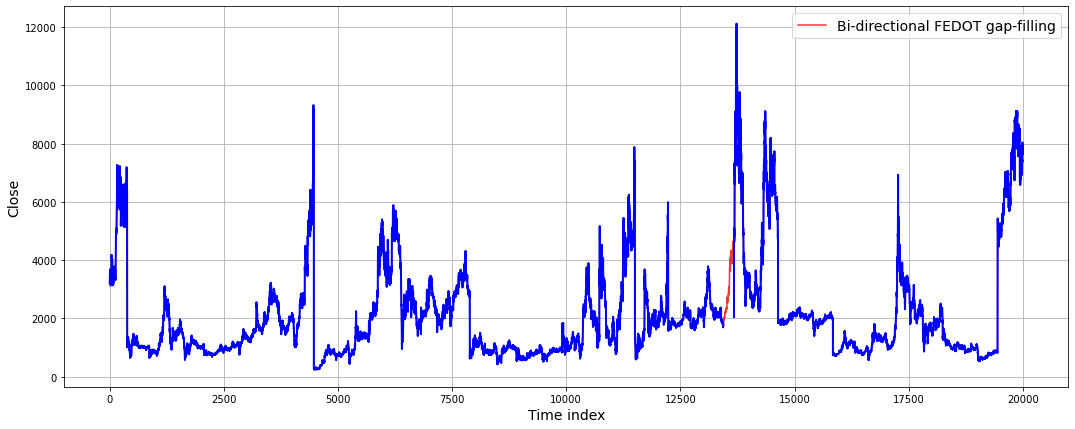

In [428]:
masked_array = np.ma.masked_where(df['Close'][480_000:500_000] == -1.0, df['Close'][480_000:500_000])
plt.plot(without_gap_bidirect, c='red', alpha=0.8, label='Bi-directional FEDOT gap-filling')
plt.plot(masked_array, c='blue', alpha=1.0, linewidth=2)
plt.ylabel('Close', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [449]:
# Define forecast length
forecast_length = len_pred

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))

# Get time series from dataframe
input_data = InputData(idx=np.arange(0, len(train_array)),
                       features=train_array,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Split data into train and test
train_input, predict_input = train_test_data_setup(input_data)

task_parameters = TsForecastingParams(forecast_length=forecast_length)

In [457]:
# Here we define which task should we use, here we also define two main forecast length
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_pred))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train_array)),
                        features=train_array,
                        target=train_array,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Prepare input data for prediction part
start_forecast = len(train_array)
end_forecast = start_forecast + len_pred
# Create forecast indices 
forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features=train_array,
                          target=None,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [459]:
model = Fedot(problem='ts_forecasting',
              task_params=task_parameters)

# Run AutoML model design in the same way
obtained_chain = model.fit(features=train_input)

# Use model to obtain forecast
forecast = model.predict(features=predict_input)

2023-05-31 18:02:31,529 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 1.9 MiB, max: 152.7 MiB
2023-05-31 18:02:31,531 - ApiComposer - Initial pipeline was fitted in 77.0 sec.
2023-05-31 18:02:31,532 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2023-05-31 18:02:31,543 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5.0 min. Set of candidate models: ['locf', 'gaussian_filter', 'sparse_lagged', 'smoothing', 'lagged', 'ar', 'cut', 'polyfit', 'glm', 'diff_filter', 'ets', 'ts_naive_average', 'locf', 'gaussian_filter', 'linear', 'sparse_lagged', 'scaling', 'smoothing', 'ar', 'adareg', 'sgdr', 'ets', 'ransac_lin_reg', 'ts_naive_average', 'ridge', 'normalization', 'ransac_non_lin_reg', 'lagged', 'pca', 'cut', 'polyfit', 'dtreg', 'glm', 'diff_filter', 'rfr', 'lasso'].
2023-05-31 18:02:31,547 - ApiComposer - Timeout is too small for composing and is skipped bec

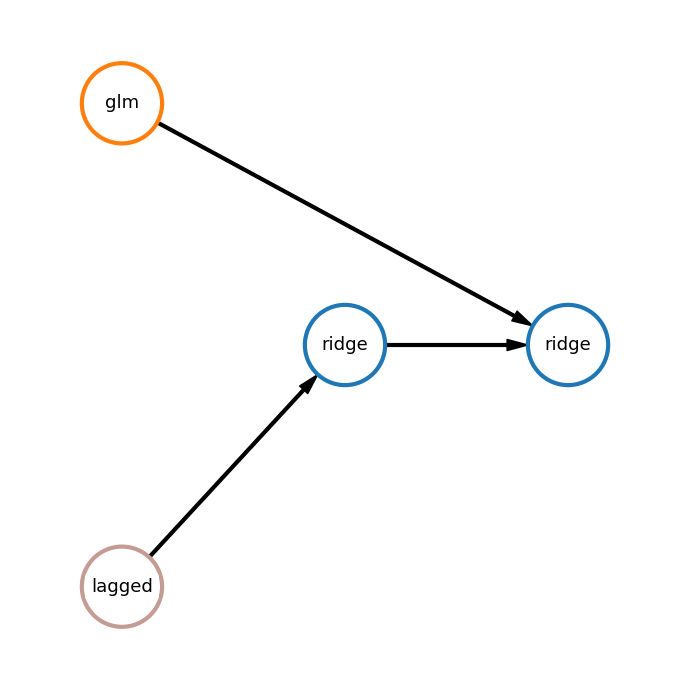

In [460]:
obtained_chain.show()

In [463]:
obtained_chain.pipeline_for_side_task

<bound method Pipeline.pipeline_for_side_task of {'depth': 3, 'length': 4, 'nodes': [ridge, glm, ridge, lagged]}>

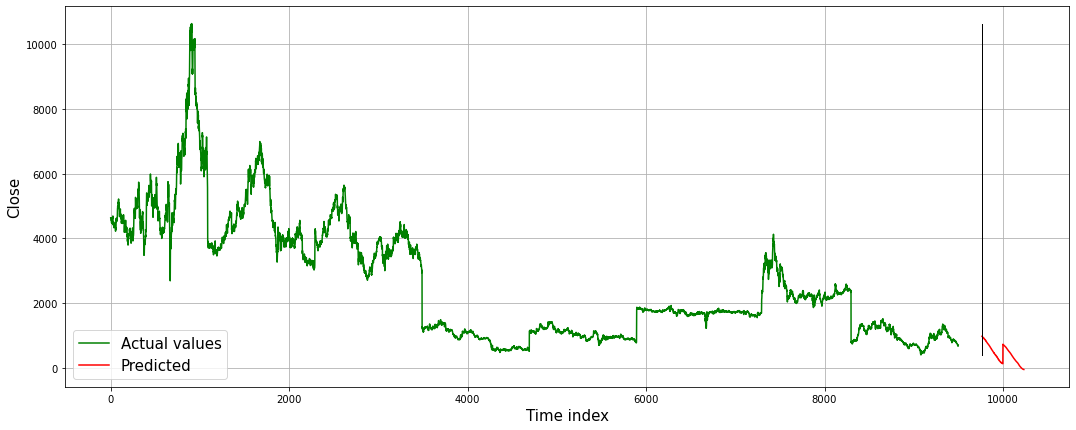

MAE: 187.941
RMSE: 268.357


In [462]:
plot_results(actual_time_series=X[500:],
             predicted_values=forecast,
             len_train_data=len(X) - forecast_length,
              y_name = 'Close')

# Print MAE metric
print(f'MAE: 187.941')
print(f'RMSE: 268.357')

In [443]:
# First level
node_lagged_1 = PrimaryNode('lagged')
node_lagged_1.parameters = {'window_size': 3}
node_lagged_2 = PrimaryNode('lagged')
node_lagged_2.parameters = {'window_size': 450}
node_smoothing = PrimaryNode('gaussian_filter')
node_smoothing.custom_params = {'sigma': 2}

# Second level
node_lagged = SecondaryNode('lagged', nodes_from=[node_smoothing])
node_lagged.custom_params = {'window_size': 30}
node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lagged_1])
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_2, node_lagged])

# Third level - root node
node_final = SecondaryNode('ridge', nodes_from=[node_knnreg, node_ridge])

complex_pipeline = Pipeline(node_final)

model_gapfiller = ModelGapFiller(gap_value=-1.0,
                                 pipeline=complex_pipeline)

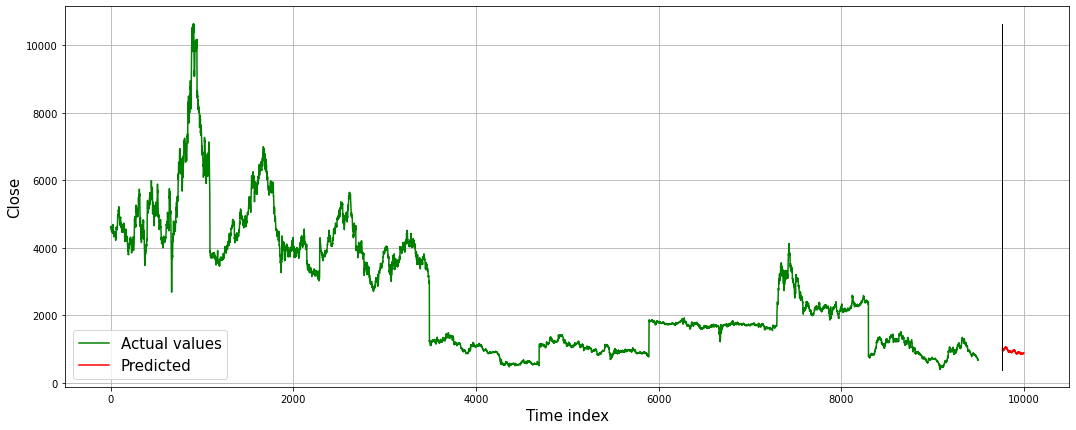

MAE: 121.477
RMSE: 164.242


In [444]:
# Here we define which task should we use, here we also define two main forecast length
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_pred))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train_array)),
                        features=train_array,
                        target=train_array,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Prepare input data for prediction part
start_forecast = len(train_array)
end_forecast = start_forecast + len_pred
# Create forecast indices 
forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features=train_array,
                          target=None,
                          task=task,
                          data_type=DataTypesEnum.ts)

# Fit pipeline
complex_pipeline.fit(train_input)

# Predict. Pipeline return OutputData object 
predicted_output = complex_pipeline.predict(predict_input)

# Convert forecasted values into one-dimensional array
predicted_values = np.ravel(np.array(predicted_output.predict))

# Plot predictions and true values
plot_results(actual_time_series = X[500:],
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Close')

# Print MAE metric
print(f'MAE: {mean_absolute_error(test_array, predicted_values):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_array, predicted_values)):.3f}')

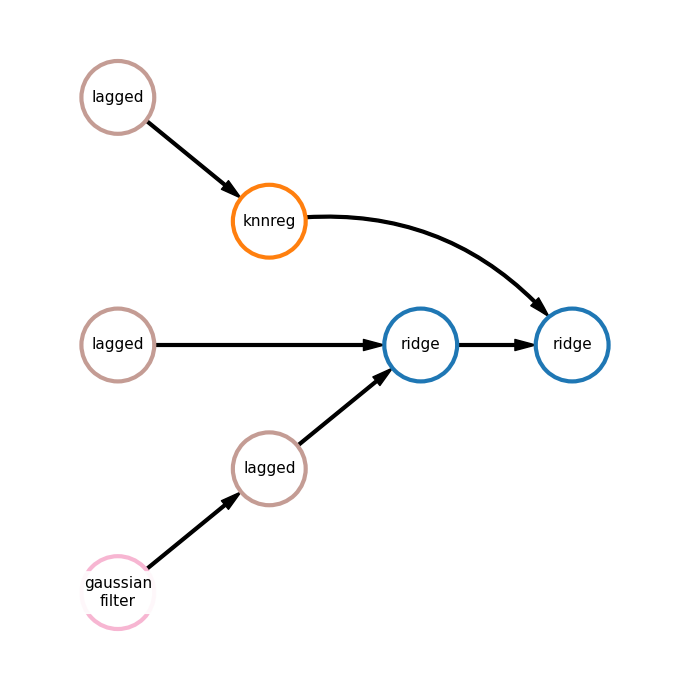

In [464]:
complex_pipeline.show()

In [465]:
complex_pipeline.pipeline_for_side_task

<bound method Pipeline.pipeline_for_side_task of {'depth': 4, 'length': 7, 'nodes': [ridge, knnreg, lagged, ridge, lagged, lagged, gaussian_filter]}>

## Preprocessing

In [466]:
X, y = preprocess_data(train)

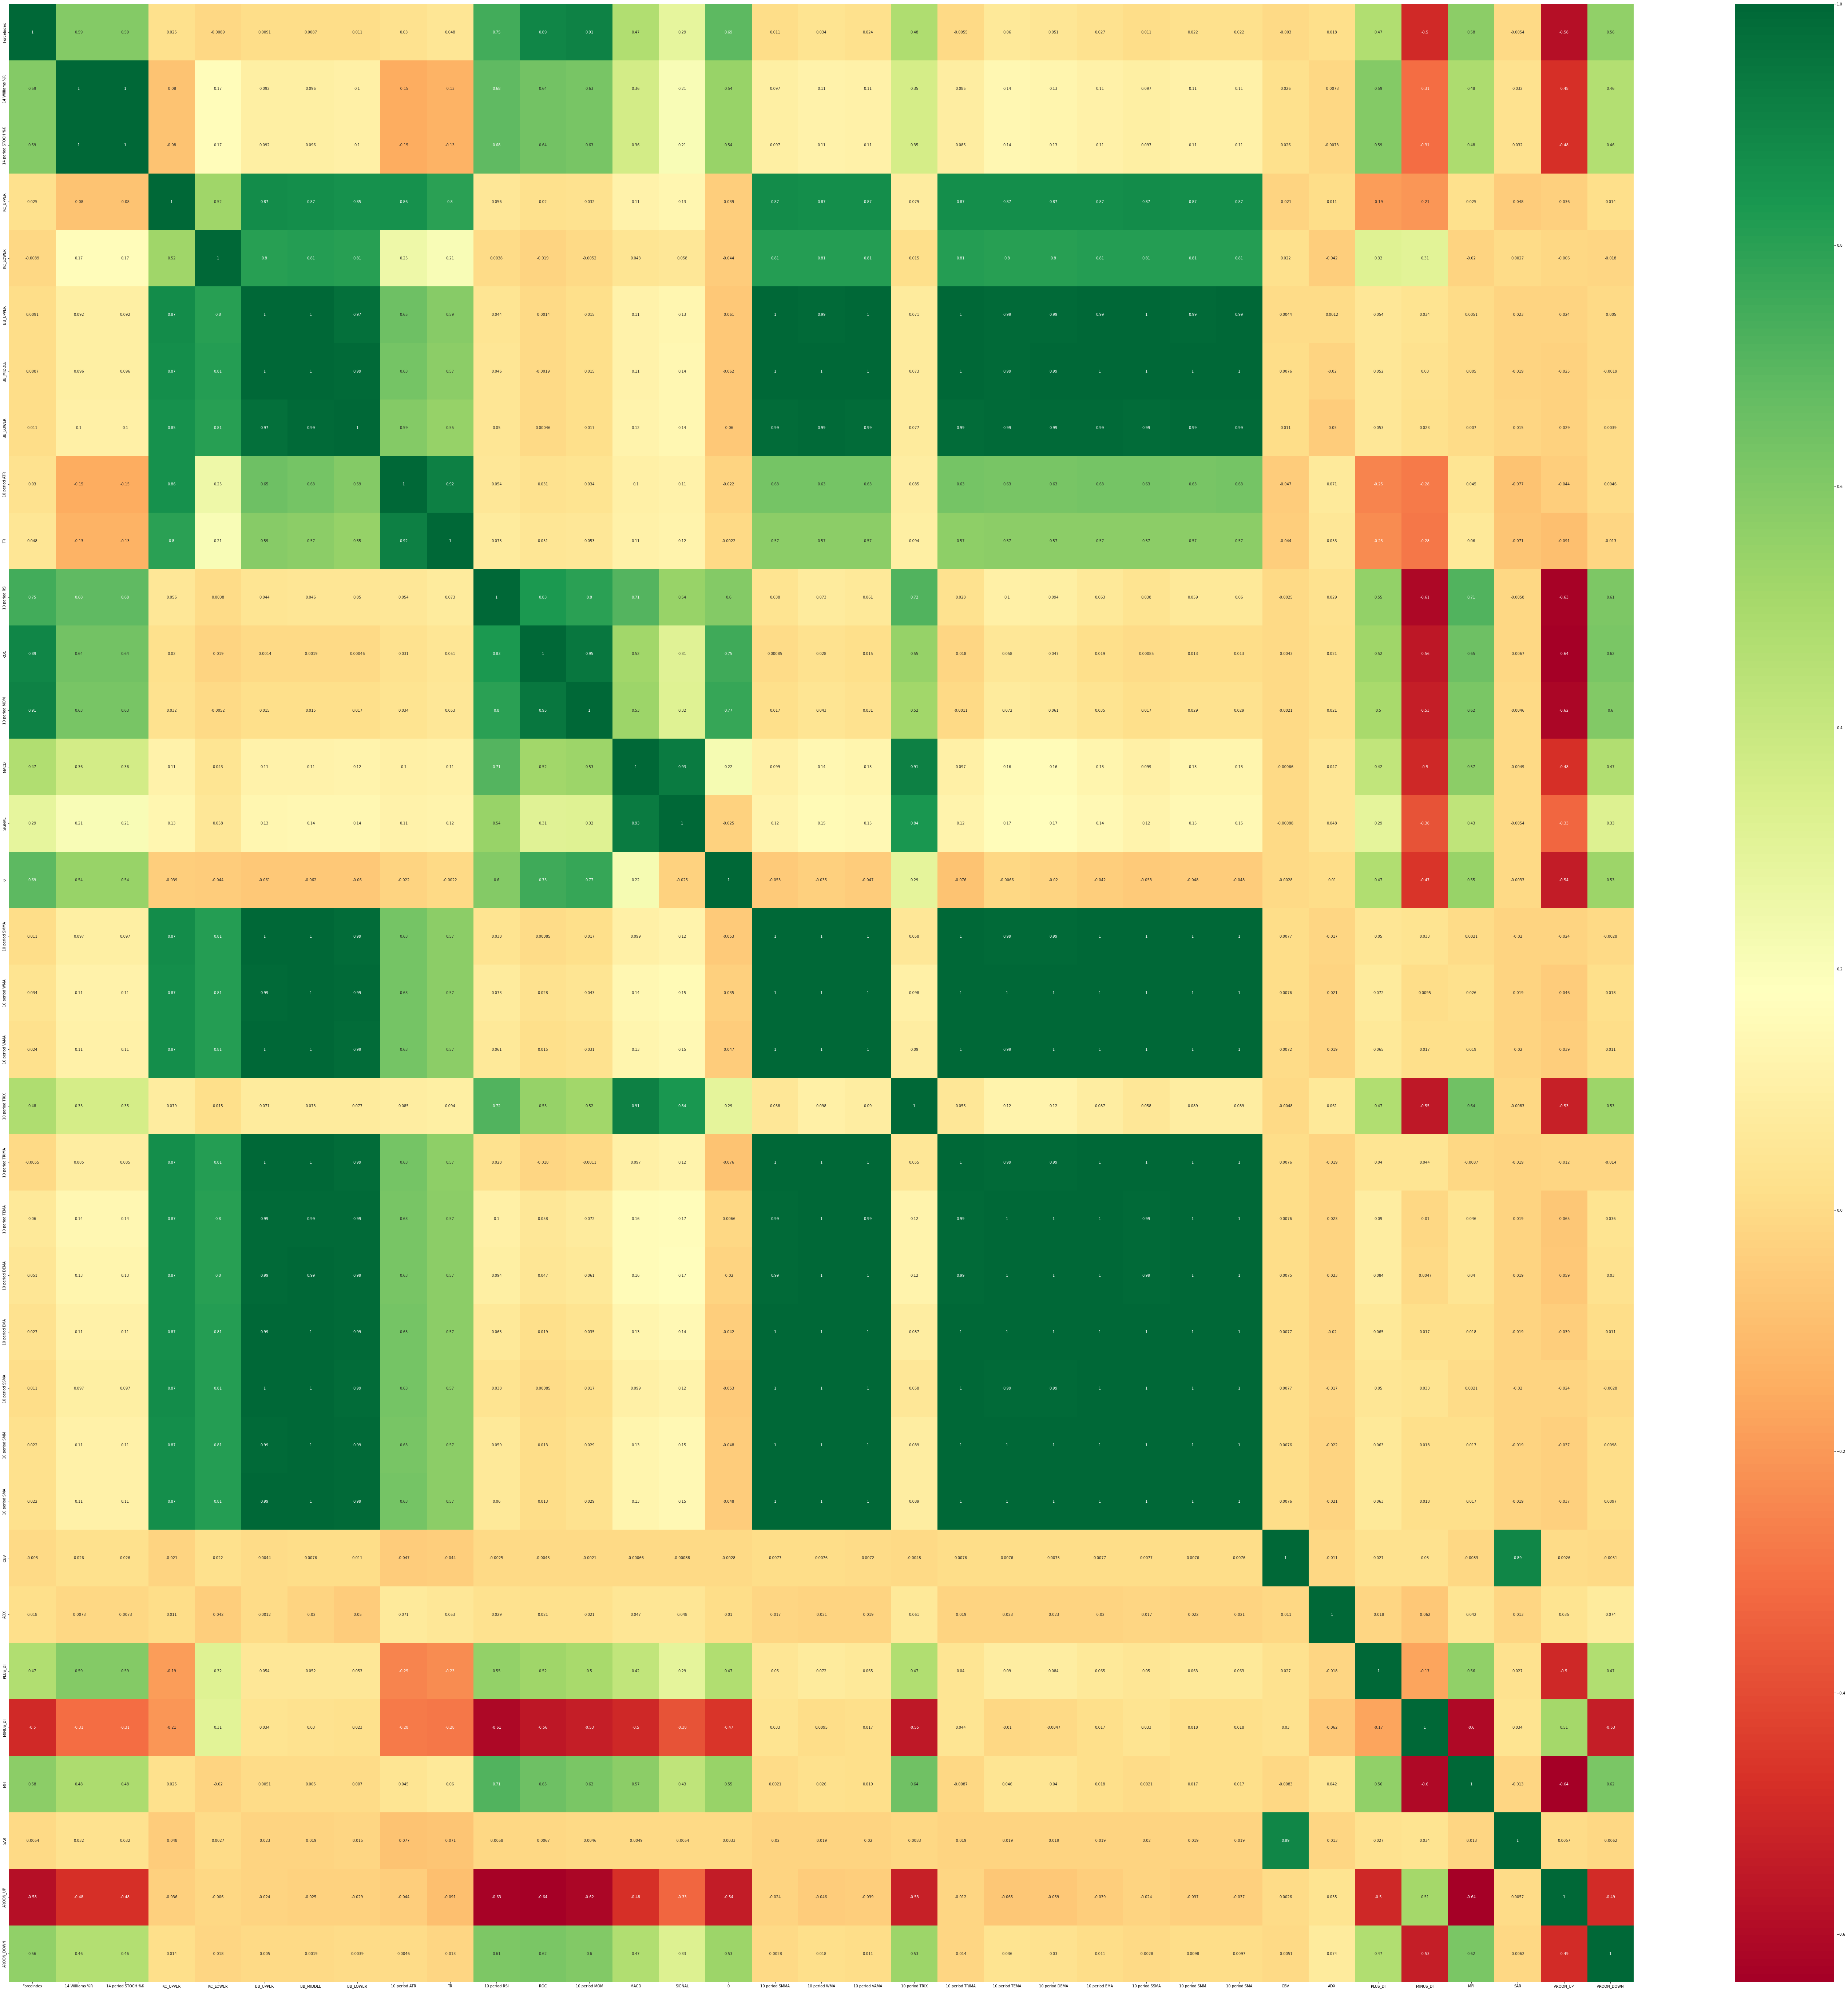

In [468]:
corr = Correlation()
corr_matrix = corr.compute_correlation(X, method="spearman")

## Model learning

In [469]:
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', stats.pearsonr(y_true, y_pred)[0], True

In [471]:
params_lgb = {'learning_rate': 0.005,
              'metric':'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [472]:
model = lgb.train(params = params_lgb, 
                train_set = lgb_train, 
                valid_sets = [lgb_train, lgb_eval], 
                num_boost_round = 5000, 
                feval=feval_pearsonr,
                callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True)])

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	training's pearsonr: 0.0638969	valid_1's pearsonr: 0.0501802
Training until validation scores don't improve for 300 rounds
[2]	training's pearsonr: 0.0638969	valid_1's pearsonr: 0.0501802
[3]	training's pearsonr: 0.0699966	valid_1's pearsonr: 0.0566336
[4]	training's pearsonr: 0.06946	valid_1's pearsonr: 0.0563273
[5]	training's pearsonr: 0.0710354	valid_1's pearsonr: 0.0581115
[6]	training's pearsonr: 0.0735478	valid_1's pearsonr: 0.0603428
[7]	training's pearsonr: 0.0738741	valid_1's pearsonr: 0.06084
[8]	training's pearsonr: 0.0751574	valid_1's pearsonr: 0.0618565
[9]	training's pearsonr: 0.0766798	valid_1's pearsonr: 0.0636605
[10]	training's pearsonr: 0.0763004	valid_1's pearsonr: 0.0629606
[11]	training's pearsonr: 0.0772479	valid_1's pearsonr: 0.0641692
[12]	training's pearsonr: 0.0770148	valid_1's pearsonr: 0.0636692

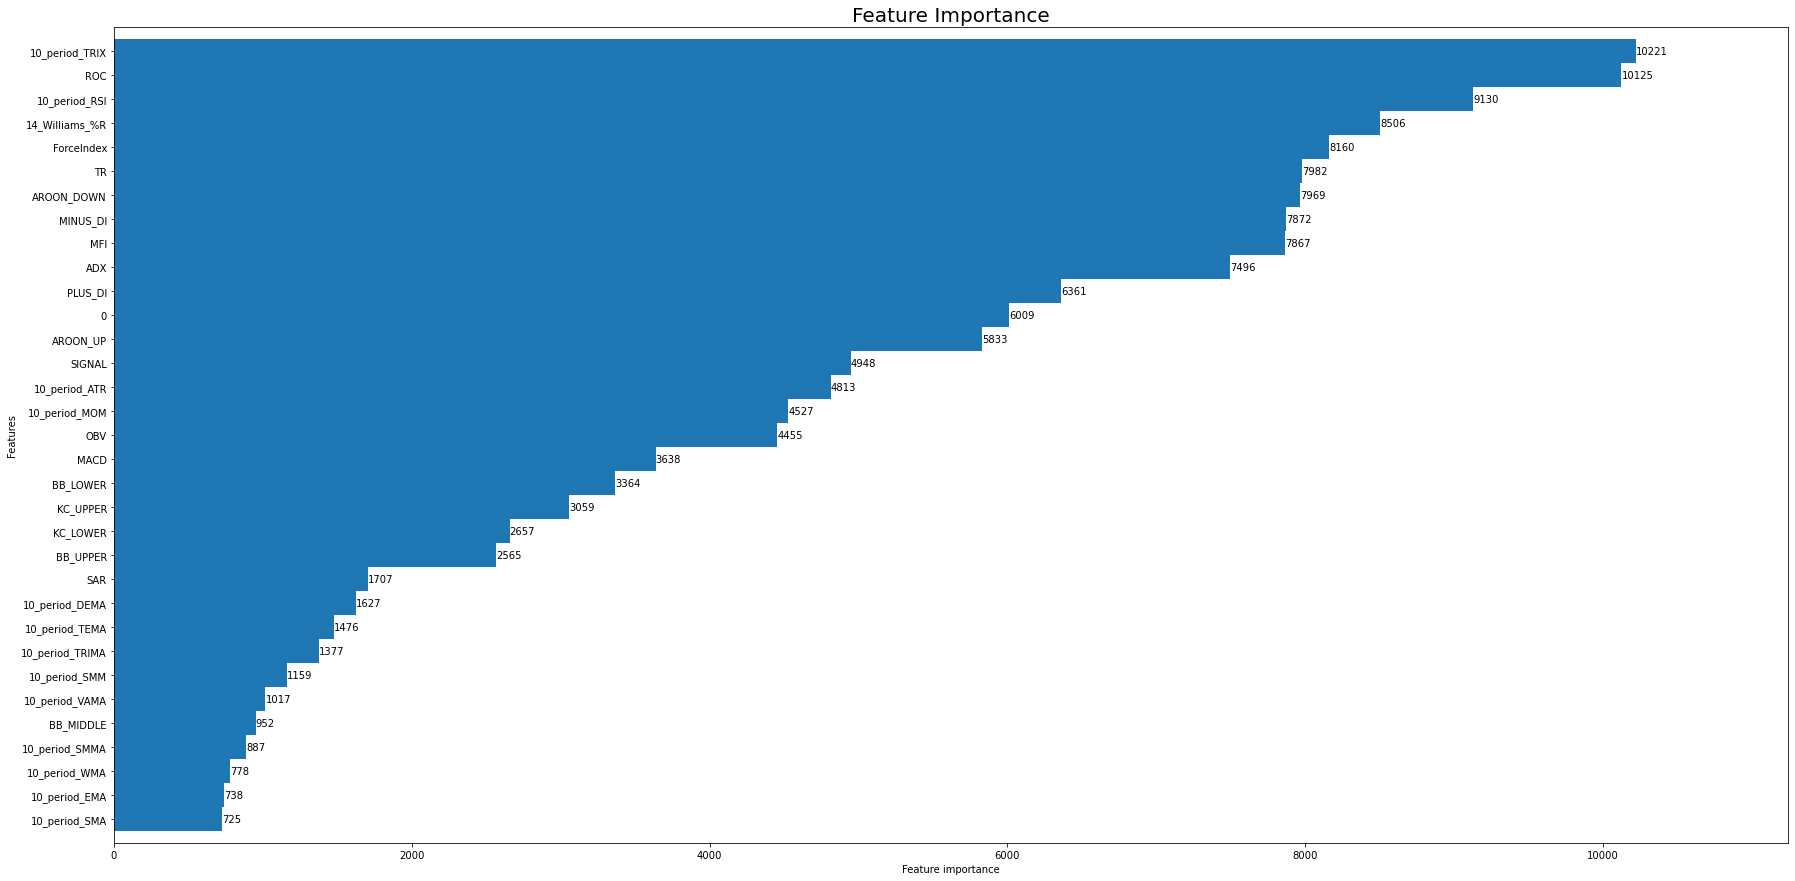

In [473]:
fig, ax = plt.subplots(figsize=(30,15))
lgb.plot_importance(model, height=1, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=20)
plt.show()

In [474]:
test_df = pd.read_csv("/Users/admin/Desktop/stock_prices_test.csv")
X_test, y_test = preprocess_data(test_df)

In [508]:
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.02721168508824882


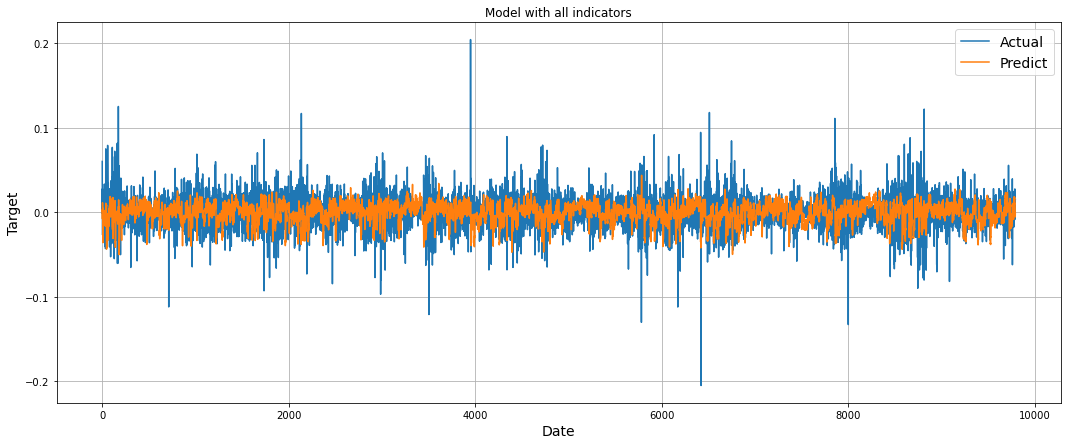

In [509]:
plt.plot(y_test.to_numpy()[260_000:], label="Actual")
plt.plot(y_pred[260_000:], label="Predict")
plt.ylabel('Target', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.title("Model with all indicators")
plt.grid()
plt.show()

## Reduce dim

In [477]:
red_features = corr.reducing_dimension(corr_matrix, 0.75)

In [481]:
X_red = X.drop(red_features, axis="columns")
X_red

ForceIndex  14 Williams %R  KC_UPPER  KC_LOWER  \
SecuritiesCode Date                                                         
1301           2017-05-17    0.001373       -0.066086 -0.002157  0.002162   
               2017-05-18    0.001909       -0.066086 -0.002157  0.002162   
               2017-05-19    0.001305       -0.066086 -0.002157  0.002162   
               2017-05-22    0.001881       -0.066086 -0.002157  0.002162   
               2017-05-23    0.001696       -0.069755 -0.002157  0.002162   
...                               ...             ...       ...       ...   
9997           2021-11-29   -0.007908       -0.122192 -0.002158  0.002161   
               2021-11-30   -0.006697       -0.122700 -0.002158  0.002161   
               2021-12-01   -0.004528       -0.110067 -0.002158  0.002161   
               2021-12-02   -0.004942       -0.110228 -0.002158  0.002161   
               2021-12-03   -0.002394       -0.103437 -0.002158  0.002161   

                           10 period RSI      MACD       OBV       ADX  \
SecuritiesCode Date                                                      
1301           2017-05-17       1.364876  0.000103 -1.800088  1.260245   
               2017-05-18       1.454728  0.000123 -1.800082  1.480271   
               2017-05-19       1.587371  0.000142 -1.800077  1.785446   
               2017-05-22       1.918990  0.000171 -1.800071  2.091151   
               2017-05-23       1.796430  0.000191 -1.800076  2.393274   
...                                  ...       ...       ...       ...   
9997           2021-11-29      -2.534452 -0.000139  1.178502  3.150907   
               2021-11-30      -2.543932 -0.000145  1.178467  3.162362   
               2021-12-01      -1.457050 -0.000142  1.178507  3.178209   
               2021-12-02      -1.478678 -0.000139  1.178466  3.160454   
               2021-12-03      -0.850079 -0.000131  1.178512  3.037790   

                            PLUS_DI  MINUS_DI       MFI  AROON_UP  AROON_DOWN  
SecuritiesCode Date                                                            
1301           2017-05-17 -0.000654 -1.164551  1.455065 -1.413419    1.261761  
               2017-05-18 -0.000654 -1.185076  1.544559 -1.413419    1.261761  
               2017-05-19 -0.000654 -1.190208  1.550741 -1.413419    0.839472  
               2017-05-22 -0.000654 -1.203280  1.626904 -1.413419    1.050617  
               2017-05-23 -0.000654 -1.319378  1.885805 -1.413419    1.261761  
...                             ...       ...       ...       ...         ...  
9997           2021-11-29 -0.000656  1.585298 -3.001900  1.315501   -1.483121  
               2021-11-30 -0.000656  1.417808 -2.488388  1.315501   -1.271976  
               2021-12-01 -0.000656  1.296206 -1.961072  1.315501   -1.483121  
               2021-12-02 -0.000656  1.113999 -1.451748  1.315501   -1.271976  
               2021-12-03 -0.000655  0.934427 -1.040869  1.315501   -1.060831  

[2332441 rows x 13 columns]

In [483]:
params_lgb = {'learning_rate': 0.005,
              'metric':'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

X_train_red, X_val_red, y_train, y_val = train_test_split(X_red, y, test_size=0.33, random_state=42)
lgb_train = lgb.Dataset(X_train_red, y_train)
lgb_eval = lgb.Dataset(X_val_red, y_val, reference=lgb_train)

In [484]:
model_red = lgb.train(params = params_lgb, 
                train_set = lgb_train, 
                valid_sets = [lgb_train, lgb_eval], 
                num_boost_round = 5000, 
                feval=feval_pearsonr,
                callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True)])

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	training's pearsonr: 0.0452445	valid_1's pearsonr: 0.0345471
Training until validation scores don't improve for 300 rounds
[2]	training's pearsonr: 0.0452445	valid_1's pearsonr: 0.0345471
[3]	training's pearsonr: 0.0501362	valid_1's pearsonr: 0.0387663
[4]	training's pearsonr: 0.0504121	valid_1's pearsonr: 0.0388403
[5]	training's pearsonr: 0.0512884	valid_1's pearsonr: 0.0396882
[6]	training's pearsonr: 0.0515309	valid_1's pearsonr: 0.0402833
[7]	training's pearsonr: 0.0516374	valid_1's pearsonr: 0.0401735
[8]	training's pearsonr: 0.0517445	valid_1's pearsonr: 0.0404217
[9]	training's pearsonr: 0.0531271	valid_1's pearsonr: 0.0410325
[10]	training's pearsonr: 0.0530661	valid_1's pearsonr: 0.041259
[11]	training's pearsonr: 0.0530642	valid_1's pearsonr: 0.0411222
[12]	training's pearsonr: 0.0540014	valid_1's pearsonr: 0.0413

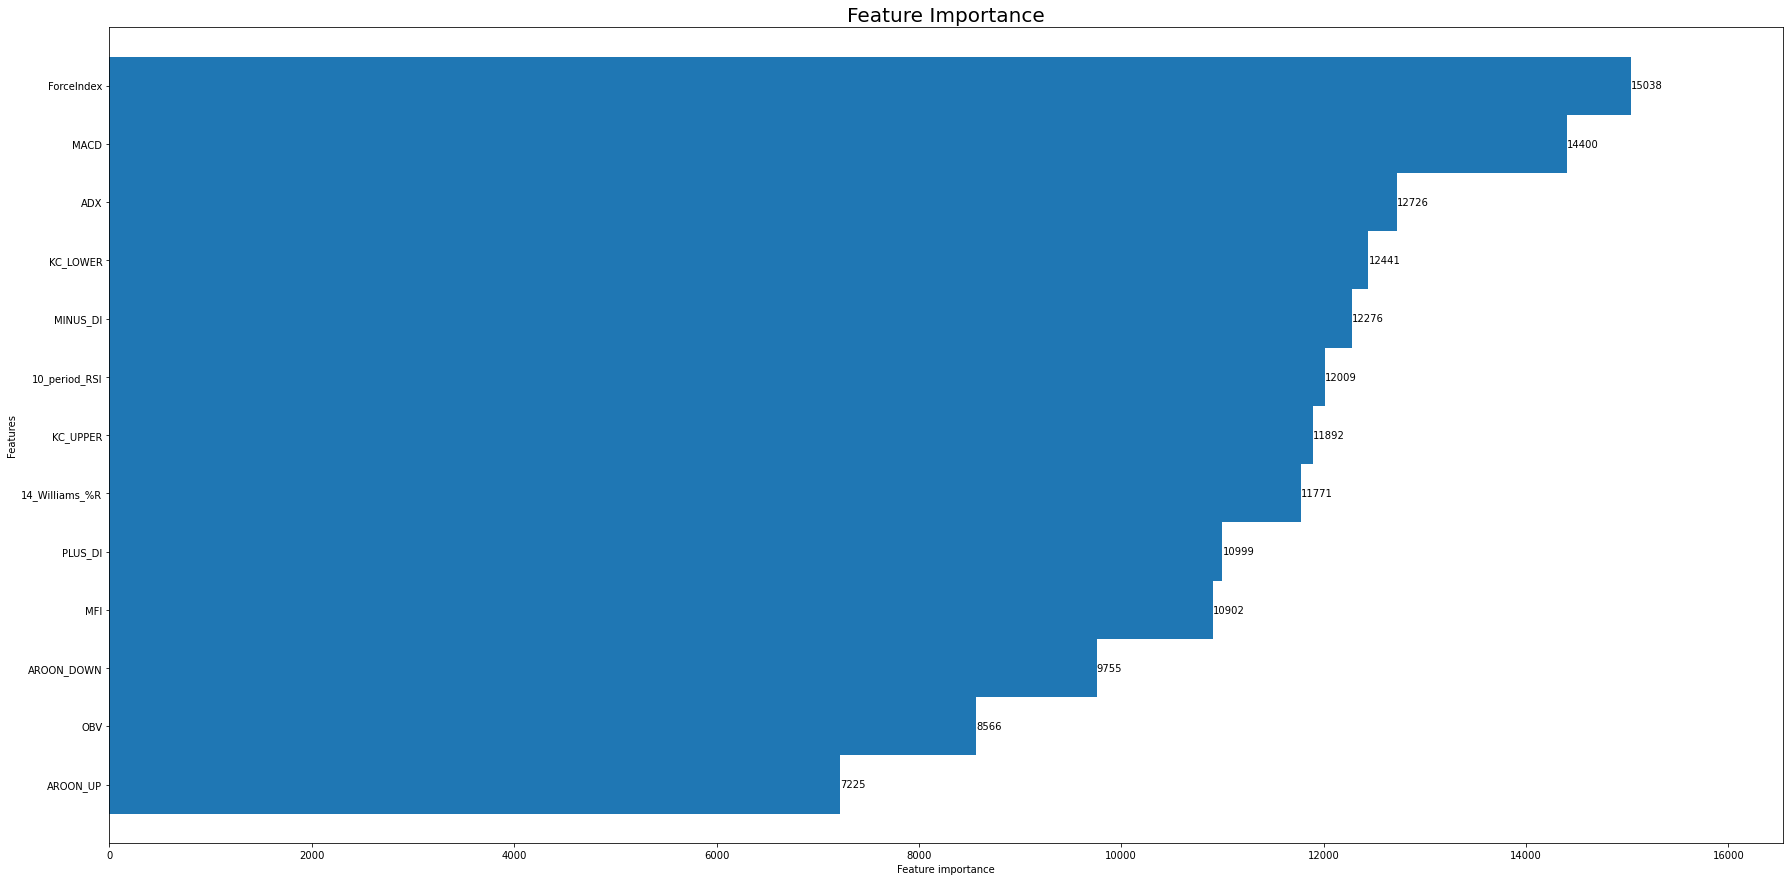

In [485]:
fig, ax = plt.subplots(figsize=(30,15))
lgb.plot_importance(model_red, height=1, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=20)
plt.show()

In [486]:
X_test_red = X_test.drop(red_features, axis="columns")

In [487]:
y_pred = model_red.predict(X_test_red)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.025819340539616188


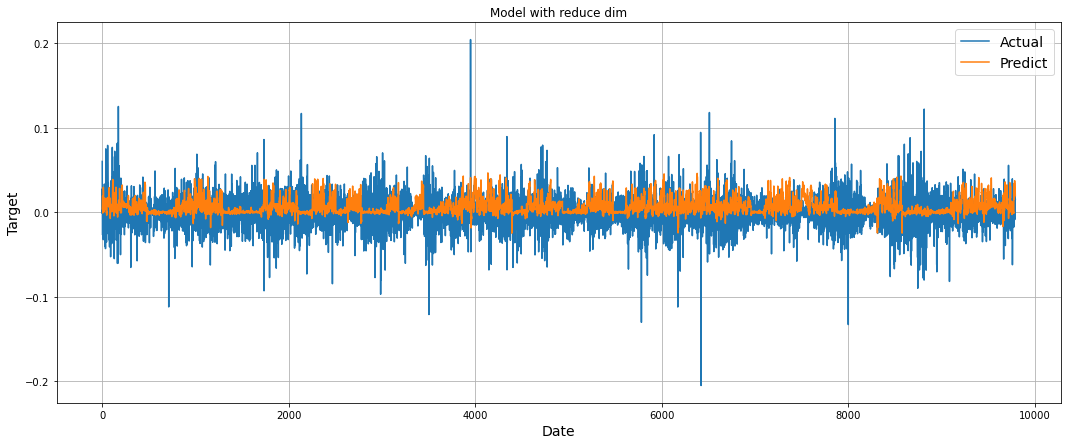

In [507]:
plt.plot(y_test.to_numpy()[260_000:], label="Actual")
plt.plot(y_pred[260_000:], label="Predict")
plt.ylabel('Target', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.title("Model with reduce dim")
plt.grid()
plt.show()